# Stacking 波士顿房价

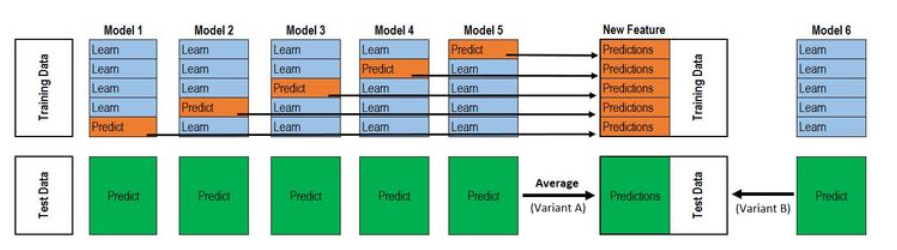

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold

In [16]:
x = load_boston().data
y = load_boston().target
x = MinMaxScaler().fit_transform(x)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3, random_state=100)
kf = KFold(n_splits=5, random_state=100, shuffle=True)
n_train = xtrain.shape[0] # 354个训练数据
n_test = xtest.shape[0]   # 152个测试数据
n_train

354

In [17]:
models = [RandomForestRegressor(n_estimators=300, random_state=100), GradientBoostingRegressor(n_estimators=300, random_state=100), 
          LGBMRegressor(n_estimators=300, random_state=100, n_jobs=1), RidgeCV(alphas=[0.0001,0.001,0.01,0.1,0.2,0.5,1,2,3,4,5,10,20,30,50]),
         LinearRegression(), SVR(kernel='rbf'), SVR(kernel='linear'), XGBRegressor(n_estimators=300), ExtraTreesRegressor(n_estimators=300, n_jobs=1, random_state=100)]
def get_off(model, x_train, y_train, x_test):
    oof_train = np.zeros((n_train,)) # 构建一个1*353的一维0矩阵
    oof_test = np.zeros((n_test,)) # 构建一个1*152的一维0矩阵
    oof_test_skf = np.zeros((5, n_test)) #5*152
    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        kf_x_train = x_train[train_index] # 每一折训练283个样本的x
        kf_y_train = y_train[train_index] # 每一折训练283个样本 y
        kf_x_test = x_train[test_index]   # 每一折测试71个样本x
        model = model.fit(kf_x_train, kf_y_train)
        oof_train[test_index] = model.predict(kf_x_test) ## 每次产生71个预测值，最终5折后成为堆叠成为1*354个训练样本的测试集
        oof_test_skf[i,:] = model.predict(x_test) ## 每次产生1*154的测试集预测值，填oof_test_skf[i,:],五次以后填满形成5*152的预测值矩阵
    oof_test[:] = oof_test_skf.mean(axis=0)  ## 把测试集的五次预测结果， 求平均，形成一次预测
    return oof_train, oof_test ## 第一个返回值为第二层模型的特征 1*354， 第二个返回值为第一层模型对测试集数据的预测1*152， 要作为第二层模型的训练集xtest

number_models = len(models)
xtrain_new = np.zeros((n_train, number_models))
xtest_new = np.zeros((n_test, number_models))
for i, regressor in enumerate(models):
    xtrain_new[:,i], xtest_new[:,i] = get_off(regressor, xtrain, ytrain, xtest)

In [20]:
print(xtrain_new.shape, ytrain.shape)

(354, 9) (354,)


In [18]:
reg = LinearRegression()
reg = reg.fit(xtrain_new, ytrain)
score = reg.score(xtest_new, ytest)
score

0.8582259643797688

In [19]:
xtrain_new.shape

(354, 9)